In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2023-02-26 10:37:20--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 142.250.31.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2023-02-26 10:37:20 (102 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5816720b-cd33-c358-fa4f-c43c19f08628)


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import *

--2023-02-26 10:37:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-26 10:37:21 (95.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
unzip_data("nlp_getting_started.zip")

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df["text"][100]

'.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad'

In [ ]:
train_df_shuffled=train_df.sample(frac=1,random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
import random
ri=random.randint(0,len(train_df_shuffled)-5)
print(ri)
for row in train_df_shuffled[["text","target"]][ri:ri+5].itertuples():

  _,text,target=row
  print(f"target:{target}","(real disaster)" if target>0 else "(not real disaster)\n",
        f"test:{text}\n",f"target:{target}\n ---\n" )

4845
target:0 (not real disaster)
 test:2 TIX 10/3 Frozen Fury XVII: Los Angeles Kings v Avalanche 103 Row:AA MGM Grand http://t.co/kBtZZZG2Tp
 target:0
 ---

target:0 (not real disaster)
 test:I BET YOU DIDNT KNOW I KICK BOX TOO! https://t.co/rBrw8pWiPJ
 target:0
 ---

target:0 (not real disaster)
 test:Exploration takes seismic shift in Gabon to Somalia - WorldOil (subscription) http://t.co/kqVEVuutDJ #??????? #Somalia
 target:0
 ---

target:0 (not real disaster)
 test:Today is Corii Siren's birthday! Spoil her now: http://t.co/l3GizRUCy4 #wishlist http://t.co/HgEDwxTDJN
 target:0
 ---

target:0 (not real disaster)
 test:each time we try we always end up sinking
 target:0
 ---



In [ ]:
from sklearn.model_selection import train_test_split
train_sentence,test_sentence,train_labels,val_label=train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                     train_df_shuffled['target'].to_numpy(),
                                                                     test_size=0.1,
                                                                     random_state=42)

In [ ]:
len(train_sentence),len(test_sentence),len(train_labels),len(val_label)

(6851, 762, 6851, 762)

In [ ]:
train_sentence[:10],train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorizer=TextVectorization(max_tokens=None,
                                  standardize="lower_and_strip_punctuation",
                                  split="whitespace",
                                  ngrams=None,
                                  output_mode="int",
                                  output_sequence_length=None,
                                  pad_to_max_tokens=False)

In [ ]:
max_vocab_length=10000
max_length=15

text_vectorizer=TextVectorization(max_tokens=max_vocab_length,
                                  output_mode='int',
                                  output_sequence_length=max_length)


In [ ]:
text_vectorizer.adapt(train_sentence)

In [ ]:
sample_sen="There is a flood on my icecream"
text_vectorizer([sample_sen])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,  11,  13,   1,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
random_sentance=random.choice(train_sentence)
print(f"Original text:\n{random_sentance}\\n\nVectorized version:")
text_vectorizer([random_sentance])



Original text:
Motorcyclist bicyclist injured in Denver collision on Broadway http://t.co/ZL7ojdAj3u\n
Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1499, 1715,  243,    4, 1145,  584,   11, 1889,    1,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
words_in_vocab=text_vectorizer.get_vocabulary()
top_5_words=words_in_vocab[:5]
bottom_5_words=words_in_vocab[-5:]
print(f"Number of word in vocab:{len(words_in_vocab)}")
print(f"5 most common words:{top_5_words}")
print(f"5 least common words:{bottom_5_words}")

Number of word in vocab:10000
5 most common words:['', '[UNK]', 'the', 'a', 'in']
5 least common words:['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
from tensorflow.keras import layers
embedding=layers.Embedding(input_dim=max_vocab_length,output_dim=128,
                           input_length=max_length )


In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentence)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01229602, -0.03764657, -0.04022679, ...,  0.02293443,
          0.01662404,  0.01672068],
        [ 0.0289866 ,  0.04897052, -0.00527909, ...,  0.04997415,
          0.02833788,  0.0284085 ],
        [-0.00288777, -0.04756198, -0.03739655, ..., -0.04639706,
          0.04179776, -0.01044533],
        ...,
        [-0.04728109, -0.00085772,  0.00952734, ..., -0.02101109,
          0.03509713,  0.00649367],
        [-0.04728109, -0.00085772,  0.00952734, ..., -0.02101109,
          0.03509713,  0.00649367],
        [-0.04728109, -0.00085772,  0.00952734, ..., -0.02101109,
          0.03509713,  0.00649367]]], dtype=float32)>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0=Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentence,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score=model_0.score(test_sentence,val_label)
print(f"Our basline model acheives an accuracy of:{baseline_score*100:.2f}%")

Our basline model acheives an accuracy of:79.27%


In [ ]:
baseline_preds=model_0.predict(test_sentence)

In [ ]:
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def calculate_results(y_true,y_pred):
  model_accuracy=accuracy_score(y_true,y_pred)
  model_precision,model_recall,model_f1,_=precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results={"accuracy":model_accuracy,
                 "precision":model_precision,
                 "recall": model_recall,
                 "f1":model_f1}
  return model_results

In [ ]:
baseline_results=calculate_results(y_true=val_label,y_pred=baseline_preds)
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Model 2

In [ ]:
SAVE_DIR="model_logs"
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_1=tf.keras.Model(inputs,outputs,name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 dense (Dense)               (None, 15, 1)             129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
train_labels.shape

(6851,)

In [ ]:
train_sentence.shape

(6851,)

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") #

In [ ]:
SAVE_DIR="model_logs"
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_1=tf.keras.Model(inputs,outputs,name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1_history = model_1.fit(train_sentence, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentence, val_label),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230226-103730
Epoch 1/5
215/215 [==============================] - 29s 109ms/step - loss: 0.6125 - accuracy: 0.6930 - val_loss: 0.5367 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4417 - accuracy: 0.8199 - val_loss: 0.4694 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3468 - accuracy: 0.8608 - val_loss: 0.4573 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2845 - accuracy: 0.8936 - val_loss: 0.4694 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2380 - accuracy: 0.9101 - val_loss: 0.4867 - val_accuracy: 0.7900


In [ ]:
model_1.evaluate(test_sentence,val_label)

24/24 [==============================] - 0s 4ms/step - loss: 0.4867 - accuracy: 0.7900


[0.48670700192451477, 0.7900262475013733]

In [ ]:
model_1_pred=model_1.predict(test_sentence)

24/24 [==============================] - 0s 3ms/step


In [ ]:
model_1_pred=tf.squeeze(tf.round(model_1_pred))
model_1_pred[:20]


<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

model_1_results = calculate_results(y_true=val_labels,

*   List item
*   List item


                                    y_pred=model_1_pred)
model_1_results

In [ ]:
model_1_results = calculate_results(y_true=val_label,y_pred=model_1_pred)
model_1_results

{'accuracy': 0.7900262467191601,
 'precision': 0.7975156487081627,
 'recall': 0.7900262467191601,
 'f1': 0.7863113264688066}

In [ ]:
val_label

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,

In [ ]:
words_in_vocab=text_vectorizer.get_vocabulary()

In [ ]:
len(words_in_vocab),words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
embed_weights=model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

In [ ]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
'''try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass'''

"try:\n  from google.colab import files\n  files.download('vectors.tsv')\n  files.download('metadata.tsv')\nexcept Exception:\n  pass"

Model-2
LSTM

In [ ]:
from tensorflow.keras import layers
inputs=layers.Input(1,dtype="string")
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.LSTM(64,return_sequences=True)(x)
x=layers.LSTM(64)(x)
x=layers.Dense(64,activation="relu")(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_2=tf.keras.Model(inputs,outputs,name="model_2_LSTM")

In [ ]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2_history=model_2.fit(train_sentence, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentence, val_label),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_2_lstm")])

Saving TensorBoard log files to: model_logs/model_2_lstm/20230226-103810
Epoch 1/5
215/215 [==============================] - 15s 46ms/step - loss: 0.2168 - accuracy: 0.9212 - val_loss: 0.6512 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1607 - accuracy: 0.9397 - val_loss: 0.5407 - val_accuracy: 0.7940
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1273 - accuracy: 0.9512 - val_loss: 0.7453 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1053 - accuracy: 0.9610 - val_loss: 0.7855 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0830 - accuracy: 0.9664 - val_loss: 1.0151 - val_accuracy: 0.7756


In [ ]:
model_2.evaluate(test_sentence,val_label)

24/24 [==============================] - 0s 4ms/step - loss: 1.0151 - accuracy: 0.7756


[1.0151318311691284, 0.7755905389785767]

In [ ]:
model_2_pred=model_2.predict(test_sentence)

24/24 [==============================] - 1s 4ms/step



model_1_results = calculate_results(y_true=val_label,
                                    y_pred=model_2_pred)
model_1_results

In [ ]:

model_2_results = calculate_results(y_true=val_label,
                                    y_pred=tf.squeeze(tf.round(model_2_pred)))
model_2_results

{'accuracy': 0.7755905511811023,
 'precision': 0.7810725814480683,
 'recall': 0.7755905511811023,
 'f1': 0.7720383798735819}

Model -3 GRU

In [ ]:
from tensorflow.keras import layers
inputs=layers.Input(1,dtype="string")
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.LSTM(64,return_sequences=True)(x)
x=layers.LSTM(64)(x)
x=layers.Dense(64,activation="relu")(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_3=tf.keras.Model(inputs,outputs,name="model_3_GRU")

In [ ]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3_history=model_3.fit(train_sentence, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentence, val_label),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_gru")])

Saving TensorBoard log files to: model_logs/model_3_gru/20230226-103838
Epoch 1/5
215/215 [==============================] - 14s 46ms/step - loss: 0.1462 - accuracy: 0.9552 - val_loss: 0.8191 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0702 - accuracy: 0.9712 - val_loss: 1.0027 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0588 - accuracy: 0.9746 - val_loss: 1.3994 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0552 - accuracy: 0.9756 - val_loss: 1.2615 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0526 - accuracy: 0.9750 - val_loss: 1.3718 - val_accuracy: 0.7743


In [ ]:
model_3.evaluate(test_sentence,val_label)

24/24 [==============================] - 0s 5ms/step - loss: 1.3718 - accuracy: 0.7743


[1.3718008995056152, 0.7742782235145569]

In [ ]:
model_3_pred =model_3.predict(test_sentence)

24/24 [==============================] - 1s 4ms/step


In [ ]:

model_3_results = calculate_results(y_true=val_label,
                                    y_pred=tf.squeeze(tf.round(model_3_pred)))
model_3_results

{'accuracy': 0.7742782152230971,
 'precision': 0.7778626718270386,
 'recall': 0.7742782152230971,
 'f1': 0.7714063189259152}

Model 4

In [ ]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype="string")
x=text_vectorizer(inputs)
x=embedding(x)
#x=layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)
x=layers.Bidirectional(layers.LSTM(64))(x)

outputs=layers.Dense(1,activation="sigmoid")(x)
model_4=tf.keras.Model(inputs,outputs,name="model_4_bidirectional")

In [ ]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_4_history=model_4.fit(train_sentence, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentence, val_label),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230226-103924
Epoch 1/5
215/215 [==============================] - 14s 46ms/step - loss: 0.1107 - accuracy: 0.9645 - val_loss: 1.0933 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0534 - accuracy: 0.9733 - val_loss: 1.1164 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0461 - accuracy: 0.9778 - val_loss: 1.3670 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0445 - accuracy: 0.9785 - val_loss: 1.4939 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0406 - accuracy: 0.9790 - val_loss: 1.2550 - val_accuracy: 0.7585


In [ ]:
model_4.evaluate(test_sentence,val_label)

24/24 [==============================] - 0s 4ms/step - loss: 1.2550 - accuracy: 0.7585


[1.2549716234207153, 0.7585301995277405]

In [ ]:
model_4_pred=model_4.predict(test_sentence)

24/24 [==============================] - 1s 3ms/step


In [ ]:
model_4_results = calculate_results(y_true=val_label,
                                    y_pred=tf.squeeze(tf.round(model_4_pred)))
model_4_results

{'accuracy': 0.7585301837270341,
 'precision': 0.758111628091943,
 'recall': 0.7585301837270341,
 'f1': 0.7578936600162789}

In [ ]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype="string")
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.Conv1D(filters=65,kernel_size=5,strides=1,activation="relu",padding="valid")(x)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_5=tf.keras.Model(inputs,outputs,name="model_5_Conv1D")

In [ ]:
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 65)            41665     
                                                                 
 global_max_pooling1d (Globa  (None, 65)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_8 (Dense)             (None, 1)              

In [ ]:
model_5_history=model_5.fit(train_sentence, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentence, val_label),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_5_convid")])

Saving TensorBoard log files to: model_logs/model_5_convid/20230226-103949
Epoch 1/5
215/215 [==============================] - 15s 43ms/step - loss: 0.1331 - accuracy: 0.9566 - val_loss: 0.8317 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0759 - accuracy: 0.9721 - val_loss: 1.0278 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0638 - accuracy: 0.9752 - val_loss: 1.0522 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0571 - accuracy: 0.9780 - val_loss: 1.1274 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0511 - accuracy: 0.9794 - val_loss: 1.1923 - val_accuracy: 0.7585


In [ ]:
model_5.evaluate(test_sentence,val_label)

24/24 [==============================] - 0s 4ms/step - loss: 1.1923 - accuracy: 0.7585


[1.192280650138855, 0.7585301995277405]

In [ ]:
model_5_pred=model_5.predict(test_sentence)
model_5_results = calculate_results(y_true=val_label,
                                    y_pred=tf.squeeze(tf.round(model_5_pred)))
model_5_results

24/24 [==============================] - 0s 2ms/step


{'accuracy': 0.7585301837270341,
 'precision': 0.7581370877027468,
 'recall': 0.7585301837270341,
 'f1': 0.7578056664430846}

model
-6 transfer learning


In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([sample_sen,
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

In [ ]:
sentence_encoder_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                     input_shape=[],
                                     dtype=tf.string,
                                     trainable=False,
                                     name="USE")

In [ ]:
model_6=tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128,activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
],name="model_6_use")
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model_6_history=model_6.fit(train_sentence, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentence, val_label),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_6 transfer")])

Saving TensorBoard log files to: model_logs/model_6 transfer/20230226-104054
Epoch 1/5
215/215 [==============================] - 7s 19ms/step - loss: 0.4718 - accuracy: 0.7828 - val_loss: 0.4390 - val_accuracy: 0.8097
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3943 - accuracy: 0.8295 - val_loss: 0.4154 - val_accuracy: 0.8241
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3673 - accuracy: 0.8413 - val_loss: 0.4145 - val_accuracy: 0.8241
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3313 - accuracy: 0.8594 - val_loss: 0.4310 - val_accuracy: 0.8215
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2855 - accuracy: 0.8848 - val_loss: 0.4725 - val_accuracy: 0.8241


In [ ]:
model_6.evaluate(test_sentence,val_label)


24/24 [==============================] - 0s 10ms/step - loss: 0.4725 - accuracy: 0.8241


[0.4725366234779358, 0.8241469860076904]

In [ ]:
model_6_pred=model_6.predict(test_sentence)
model_6_results = calculate_results(y_true=val_label,
                                    y_pred=tf.squeeze(tf.round(model_6_pred)))
model_6_results

24/24 [==============================] - 1s 9ms/step


{'accuracy': 0.8241469816272966,
 'precision': 0.8342103701079485,
 'recall': 0.8241469816272966,
 'f1': 0.8208997545464594}

In [ ]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
'''train_10_percent=train_df_shuffled[["text","target"]].sample(frac=0.1,random_state=42)
train_sentences_10_percent=train_10_percent["text"].tolist()
train_labels_10_percent=train_10_percent["target"].tolist()
len(train_sentences_10_percent),len(train_labels_10_percent)'''

'train_10_percent=train_df_shuffled[["text","target"]].sample(frac=0.1,random_state=42)\ntrain_sentences_10_percent=train_10_percent["text"].tolist()\ntrain_labels_10_percent=train_10_percent["target"].tolist()\nlen(train_sentences_10_percent),len(train_labels_10_percent)'

In [ ]:
train_10_percent_split=int(0.1*len(train_sentence))
train_senetence_10=train_sentence[:train_10_percent_split]
train_labels_10=train_labels[:train_10_percent_split]

In [ ]:
#train_labels_10.value_counts()

model 7 -10 percent

In [ ]:
model_7=tf.keras.models.clone_model(model_6)
model_7.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
model_7.summary()

Model: "model_6_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,871,809
Trainable params: 73,985
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_7_history=model_7.fit(train_senetence_10, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels_10,
                              epochs=5,
                              validation_data=(test_sentence, val_label),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_7_10 percent")])

Saving TensorBoard log files to: model_logs/model_7_10 percent/20230226-104123
Epoch 1/5
22/22 [==============================] - 5s 49ms/step - loss: 0.6630 - accuracy: 0.6467 - val_loss: 0.6282 - val_accuracy: 0.6824
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5448 - accuracy: 0.7912 - val_loss: 0.5186 - val_accuracy: 0.7717
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4236 - accuracy: 0.8204 - val_loss: 0.4808 - val_accuracy: 0.7795
Epoch 4/5
22/22 [==============================] - 0s 22ms/step - loss: 0.3525 - accuracy: 0.8467 - val_loss: 0.4881 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 0s 23ms/step - loss: 0.2993 - accuracy: 0.8832 - val_loss: 0.5128 - val_accuracy: 0.7703


In [ ]:
model_7_pred=model_7.predict(test_sentence)
model_7.evaluate(test_sentence,val_label)

24/24 [==============================] - 0s 11ms/step - loss: 0.5128 - accuracy: 0.7703


[0.5128121972084045, 0.7703412175178528]

In [ ]:
model_7_results = calculate_results(y_true=val_label,
                                    y_pred=tf.squeeze(tf.round(model_7_pred)))
model_7_results

{'accuracy': 0.7703412073490814,
 'precision': 0.7702878929185921,
 'recall': 0.7703412073490814,
 'f1': 0.769333028556703}

In [ ]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
model_6_results

{'accuracy': 0.8241469816272966,
 'precision': 0.8342103701079485,
 'recall': 0.8241469816272966,
 'f1': 0.8208997545464594}

In [ ]:
all_model_results=pd.DataFrame({"0_baseline":baseline_results,
                                "1_simple_dense":model_1_results,
                                "2_lstm":model_2_results,
                                "3_gru":model_3_results,
                                "4_bidirectional":model_4_results,
                                "5_convid":model_5_results,
                                "6_tf_hub_use_encoder":model_6_results,
                                "7_tF_hub_use_encoder_10_percent":model_7_results})

In [ ]:
all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.790026,0.797516,0.790026,0.786311
2_lstm,0.775591,0.781073,0.775591,0.772038
3_gru,0.774278,0.777863,0.774278,0.771406
4_bidirectional,0.758530,0.758112,0.758530,0.757894
5_convid,0.758530,0.758137,0.758530,0.757806
6_tf_hub_use_encoder,0.824147,0.834210,0.824147,0.820900
7_tF_hub_use_encoder_10_percent,0.770341,0.770288,0.770341,0.769333


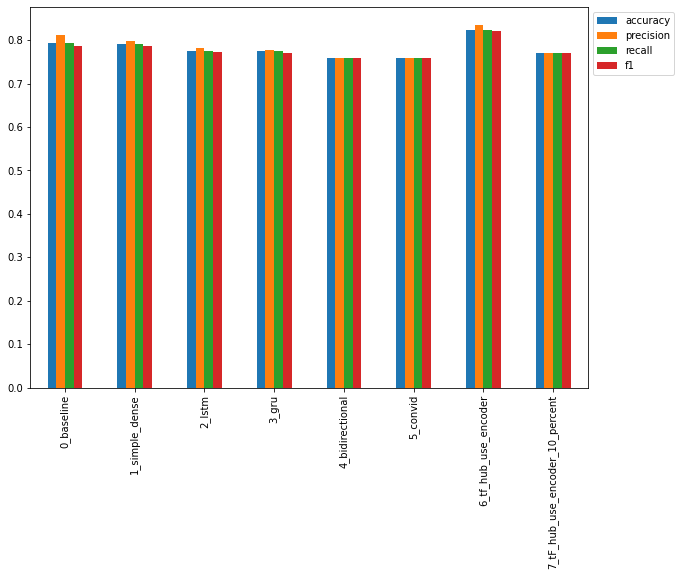

In [ ]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<AxesSubplot:>

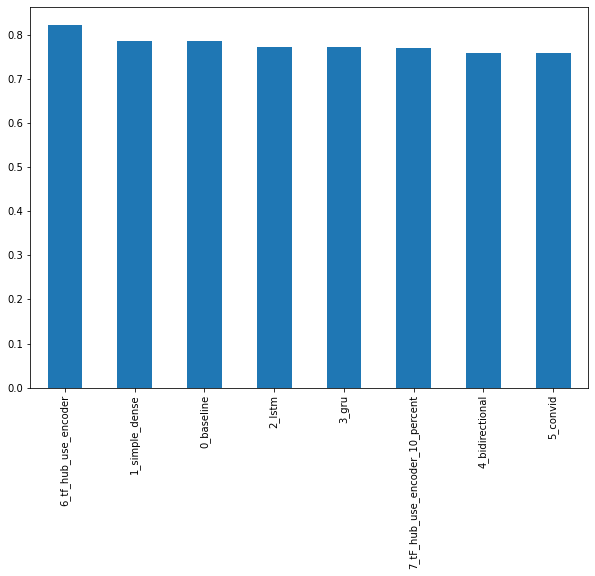

In [ ]:
all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

In [ ]:
'''!tensorboard dev upload --logdir ./model_logs \
  --name "NLP models on kaggle tweets text classifier dataset" \
  --description "Comparing different types of model architecture on kaggle tweets text classification datasset" \
  --one_shot'''

2023-02-26 10:41:35.090096: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-26 10:41:35.090219: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-26 10:41:35.090242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs

This TensorBoard wil

In [ ]:
#!tensorboard dev list


2023-02-26 10:42:22.441869: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-26 10:42:22.441975: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-26 10:42:22.441995: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/r877rVRCRMWYYd9sEiexdg/
	Name                 NLP models on kaggle tweets text classifier dataset
	Description          Comparing di

In [ ]:
#!tensorboard dev delete --experiment_id SmJ2LOfRQ72Nkg7ckMvKAQ

Need custom hub layer if using loading transfer learning object

In [ ]:
model_6.save("model_6.h5")

In [ ]:
import tensorflow_hub as hub
loaded_model_6=tf.keras.models.load_model("model_6.h5",custom_objects={"KerasLayer":hub.KerasLayer})

In [ ]:
loaded_model_6.evaluate(test_sentence,val_label)

24/24 [==============================] - 1s 10ms/step - loss: 0.4725 - accuracy: 0.8241


[0.4725365936756134, 0.8241469860076904]

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-02-26 10:42:41--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.128, 142.251.16.128, 142.251.163.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   218MB/s    in 4.3s    

2023-02-26 10:42:45 (215 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables

In [ ]:
model_6_pretrained=tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(test_sentence,val_label)

24/24 [==============================] - 2s 18ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [ ]:
model_6_pretrained_probs=model_6_pretrained.predict(test_sentence)
model_6_pretrained_preds=tf.squeeze(tf.round(model_6_pretrained_probs))

24/24 [==============================] - 1s 22ms/step


In [ ]:
val_df=pd.DataFrame({"text":test_sentence,
                     "target":val_label,
                     "pred":model_6_pretrained_preds,
                     "pred_probs":tf.squeeze(model_6_pretrained_probs)})

In [ ]:
val_df

,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.137074
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.095865
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
760,Crack in the path where I wiped out this morni...,0,1.0,0.612631


In [ ]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_probs", ascending=False)
most_wrong[:10]

,text,target,pred,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [ ]:
most_wrong.tail(10)

,text,target,pred,pred_probs
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.067303
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.055076
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.054603
221,going to redo my nails and watch behind the sc...,1,0.0,0.054597
59,You can never escape me. Bullets don't harm me...,1,0.0,0.049637
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [ ]:
for row in most_wrong[:10].itertuples():
  _,text,target,pred,pred_prob=row
  print(f"Target:{target},pred:{pred}, prob{pred_prob}.")
  print(f"Text:\n{text}\n")
  print("--\n")


Target:0,pred:1.0, prob0.9101957678794861.
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

--

Target:0,pred:1.0, prob0.8769821524620056.
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

--

Target:0,pred:1.0, prob0.8523000478744507.
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

--

Target:0,pred:1.0, prob0.8354544639587402.
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

--

Target:0,pred:1.0, prob0.8272132873535156.
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

--

Target:0,pred:1.0, prob0.814815878868103.
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

--

Target:0,pred:1.0, prob0.810839653

In [ ]:
for row in most_wrong[-10:].itertuples():
  _,text,target,pred,pred_prob=row
  print(f"Target:{target},pred:{pred}, prob{pred_prob}.")
  print(f"Text:\n{text}\n")
  print("--\n")


Target:1,pred:0.0, prob0.06730346381664276.
Text:
@DavidVonderhaar At least you were sincere ??

--

Target:1,pred:0.0, prob0.05507583171129227.
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

--

Target:1,pred:0.0, prob0.054603397846221924.
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

--

Target:1,pred:0.0, prob0.054597001522779465.
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

--

Target:1,pred:0.0, prob0.04963727295398712.
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

--

Target:1,pred:0.0, prob0.043918490409851074.
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

--

Target:1,pred:0.0, prob0.042086850851774216.
Text:
I get to smoke

In [ ]:
test_sen=test_df["text"].tolist()
test_samples=random.sample(test_sen,10)
for test_sample in test_samples:
  pred_prob=tf.squeeze(model_6_pretrained.predict(test_samples))
  pred=tf.round(pred_prob)
  print(f"Pred: {pred}, Prob:{pred_prob}")
  print(f"Text:\n{test_sample}\b")
  print("---\n")

1/1 [==============================] - 0s 41ms/step
Pred: [1. 1. 0. 0. 0. 1. 0. 0. 0. 0.], Prob:[0.81501603 0.71390283 0.43988258 0.04436533 0.28774145 0.9491787
 0.18295161 0.07034872 0.13789262 0.38004863]
Text:
Aug 3 1915ÛÓKAISERJAEGERS WIPED OUT.; Francis Joseph's Crack Regiment Annihilated on Carso Plateau.
http://t.co/D1sPSwl66H
---

1/1 [==============================] - 0s 42ms/step
Pred: [1. 1. 0. 0. 0. 1. 0. 0. 0. 0.], Prob:[0.81501603 0.71390283 0.43988267 0.04436533 0.2877415  0.9491787
 0.18295158 0.07034872 0.13789262 0.38004863]
Text:
Bay Whale Worries Rescuers http://t.co/nfKTvVLWHm
---

1/1 [==============================] - 0s 38ms/step
Pred: [1. 1. 0. 0. 0. 1. 0. 0. 0. 0.], Prob:[0.81501603 0.7139028  0.43988267 0.04436531 0.28774154 0.9491787
 0.18295158 0.07034869 0.13789262 0.38004857]
Text:
matako_milk: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.
---

1/1 [========================

In [ ]:
import time
def pred_timer(model,samples):
  ''' Times how long model takes to predict samples'''
  start_time=time.perf_counter()
  model.predict(samples)
  end_time=time.perf_counter()
  total_time=end_time-start_time
  time_per_pred= total_time/len(samples)
  return total_time,time_per_pred

In [ ]:
model_0_total_pred_time,model_0_time_per_pred=pred_timer(model=model_0,
                                                         samples=test_sentence)
model_0_total_pred_time,model_0_time_per_pred

(0.03264161499964757, 4.2836765091401015e-05)

In [ ]:
model_6_total_pred_time,model_6_time_per_pred=pred_timer(model=model_6_pretrained,
                                                         samples=test_sentence)
model_6_total_pred_time,model_6_time_per_pred

24/24 [==============================] - 1s 22ms/step


(0.7991095460001816, 0.001048700191601288)

In [ ]:
model_6_pretrained_results=calculate_results(y_true=val_label,
                                             y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 0.8162729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

Text(0, 0.5, 'F1-score')

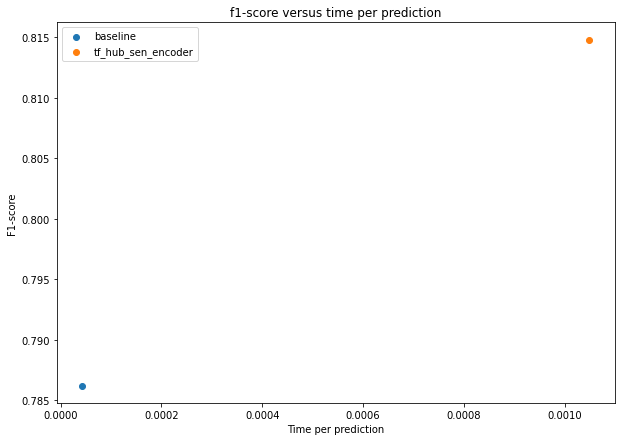

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(model_0_time_per_pred,baseline_results["f1"],label="baseline")
plt.scatter(model_6_time_per_pred,model_6_pretrained_results["f1"],label="tf_hub_sen_encoder")
plt.legend()
plt.title("f1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")